In [360]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [361]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
data_directory = './data/lunar/training/data/S12_GradeA/'

WINDOW_SIZE = 8000
STEP_SIZE = 2000
MEAN_AMPLITUDE_FACTOR = 1.1

cat = pd.read_csv(cat_file)

In [362]:
# Power, bandwidth, spectral entropy, peak frequency, dominant frequency, centroid frequency, mean frequency and spectral amplitude

def get_power(dataframe):
    # The power of a signal is the sum of the squares of the absolute values of the signal's time-domain samples divided by the signal length
    data = dataframe.data

    return np.sum(np.abs(data)**2)

def get_bandwidth(dataframe):
    # The bandwidth of a signal is the range of frequencies that it contains
    data = dataframe.data
    fft = np.fft.fft(data)

    return np.sum(np.abs(fft)**2)

def get_spectral_entropy(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)
    power = np.abs(fft)**2
    power = power / np.sum(power)  # Normalización
    power = power[power > 0]  # Evitar log(0)

    return -np.sum(power * np.log(power))

def get_spectral_amplitude(dataframe):
    data = dataframe.data

    fft = np.fft.fft(data)

    return np.max(np.abs(fft))

def get_mean_amplitude(dataframe):
    data = dataframe.data

    return np.mean(np.abs(data))

def get_characteristics(dataframe):
    return dict(
        # power=get_power(dataframe),
        # bandwidth=get_bandwidth(dataframe),
        mean_amplitude=get_mean_amplitude(dataframe),
        # spectral_entropy=get_spectral_entropy(dataframe),
        spectral_amplitude=get_spectral_amplitude(dataframe)
    )

def get_file_data(index: int):
    catalog_row = cat.iloc[index]

    filename = catalog_row.filename

    csv_file = f'{data_directory}{filename}.csv'
    data_cat = pd.read_csv(csv_file)

    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    return pd.DataFrame(dict(
        time=csv_times,
        data=csv_data
    ))

def get_windowed_data(dataframe, offset=0, window_size=WINDOW_SIZE):
    result = []
    data = dataframe.data
    times = dataframe.time

    for i in range(offset, offset + window_size):
        if i >= len(data):
            break

        row = dict(
            time=times[i],
            data=data[i]
        )
        result.append(row)
    
    return pd.DataFrame(result)

def get_tagged_data(untagged_data):
    list = []
    times = untagged_data['times']
    data = untagged_data['data']
    event_time = untagged_data['event_time']

    for i in range(len(times)):
        row = dict(
            time=times[i],
            data=data[i],
            type = 0 if times[i] < event_time else 1
        )
        list.append(row)
    
    return pd.DataFrame(list)

def get_window_type(window):
    # if there is only 0s, is a non-event window
    if np.all(window.type == 0):
        return 0
    # if there is only 1s, is a non-event window
    if np.all(window.type == 1):
        return 2
    # if there is at least one 1, is an event window
    if np.any(window.type == 1):
        return 1
    
    return -1
    

def get_dataset_characteristics():
    characteristics = []
    limit = cat.shape[0]

    for i in range(1, limit):
        row = cat.iloc[i]
        filename = row.filename

        csv_file = f'{data_directory}{filename}.csv'
        data_cat = pd.read_csv(csv_file)

        csv_times = np.array(data_cat['time_rel(sec)'].tolist())
        csv_data = np.array(data_cat['velocity(m/s)'].tolist())

        characteristics.append(dict(
            **get_characteristics(csv_data, csv_times)
        ))
        print(f'Processed training file {i}/{limit - 1} ({filename})')

    return pd.DataFrame(characteristics, ignore_index=True)

def get_windows_characteristics(windows):
    characteristics = []

    for i in range(len(windows)):
        window = windows[i]
        window_type = get_window_type(window)

        characteristics.append(dict(
            is_event=1 if window_type == 1 else 0,
            **get_characteristics(window)
        ))
        print(f'Processed window {i}/{len(windows)}')

    return pd.DataFrame(characteristics)

def get_start_event_window(dataframe):
    max_spectral_amplitude = float('-inf')
    max_spectral_amplitude_index = 0

    for offset in range(0, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, offset)
        characteristics = get_characteristics(window)

        if characteristics['spectral_amplitude'] > max_spectral_amplitude:
            max_spectral_amplitude = characteristics['spectral_amplitude']
            max_spectral_amplitude_index = offset
    
    # Go back 2 windows to get the start of the event

    max_spectral_amplitude_index -= 2 * STEP_SIZE
    
    return get_windowed_data(dataframe, max_spectral_amplitude_index), max_spectral_amplitude_index

def get_end_event_window(dataframe, event_window_index):
    # Starting in the event time, get the first window that its mean amplitude is less than the mean amplitude of the event window

    window_mean_amplitude = get_characteristics(dataframe)['mean_amplitude'] * MEAN_AMPLITUDE_FACTOR

    for i in range(event_window_index, len(dataframe), STEP_SIZE):
        window = get_windowed_data(dataframe, i, WINDOW_SIZE)
        mean_amplitude = get_mean_amplitude(window)

        if mean_amplitude < window_mean_amplitude:
            return window, i

    return None, None
    

In [363]:
def plot_test(index):
    file_index = index
    dataframe = get_file_data(file_index)
    

    _, start_event_window_index = get_start_event_window(dataframe)
    end_event_window, end_event_window_index = get_end_event_window(dataframe, start_event_window_index)

    print(f'Start event window: {start_event_window_index}')
    print(f'End event window: {end_event_window_index}')

    final_test = get_file_data(file_index)
    times = final_test.time
    data = final_test.data

    # plot
    fig,ax = plt.subplots(1,1,figsize=(10,3))
    ax.plot(times, data)

    event_mean_amplitude = get_mean_amplitude(end_event_window)

    # Plot event mean amplitude
    ax.axhline(event_mean_amplitude, color='r', linestyle='--', label=f'Event mean amplitude ({event_mean_amplitude:.2f})')

    # Make the plot pretty
    ax.set_xlim([min(times), max(times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'File index {index}', fontweight='bold')


    # Plot where the event window is
    event_window_times = dataframe.time[start_event_window_index:end_event_window_index]
    event_window_data = dataframe.data[start_event_window_index:end_event_window_index]
    event_window_line = ax.plot(event_window_times, event_window_data, c='purple', label=f'Event window (mean amplitude: {event_mean_amplitude:.2f})')
    ax.legend(handles=event_window_line)

    plt.show()

Start event window: 488000
End event window: 560000


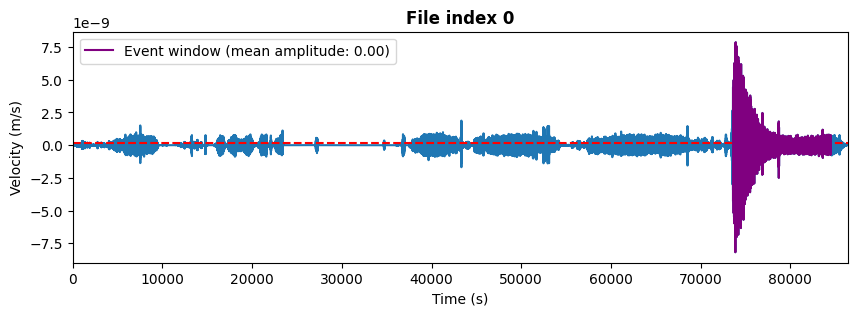

Start event window: 86000
End event window: 102000


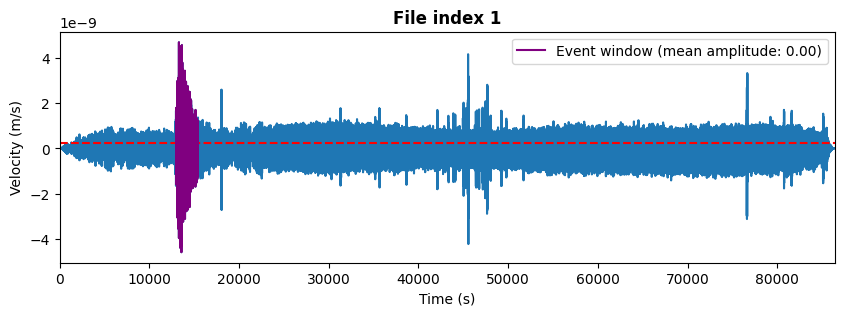

Start event window: 484000
End event window: 508000


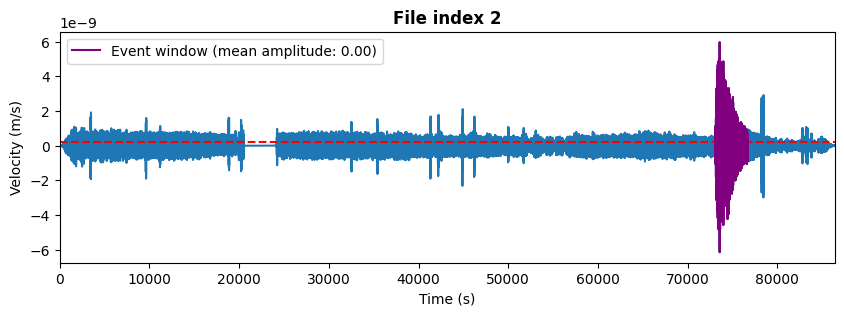

Start event window: 30000
End event window: 60000


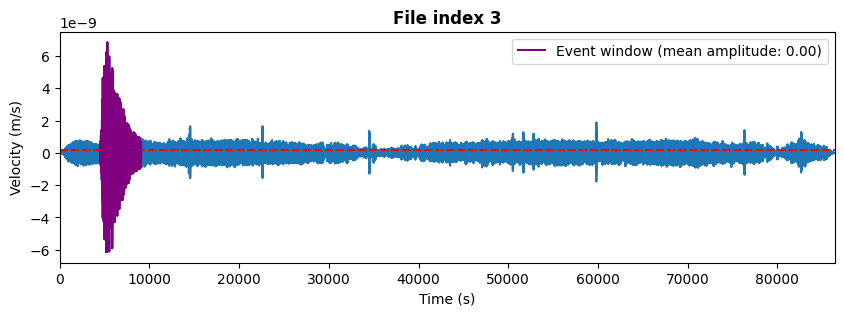

Start event window: 346000
End event window: 392000


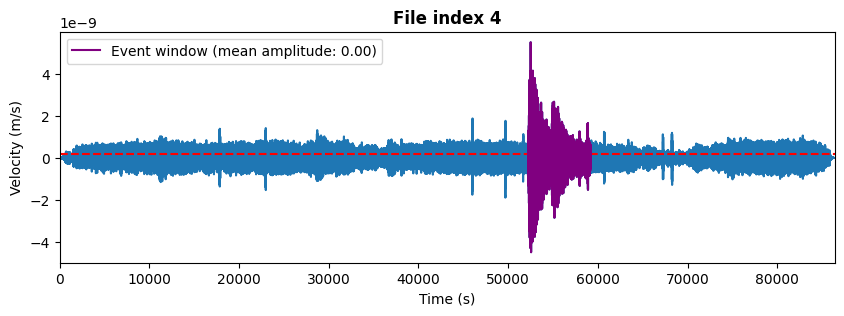

Start event window: 454000
End event window: 480000


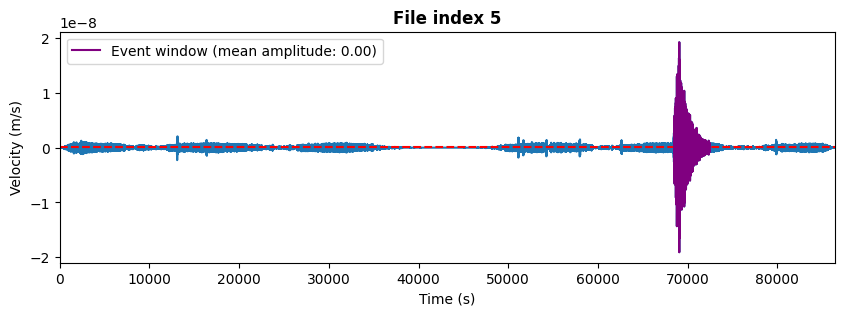

Start event window: 480000
End event window: 512000


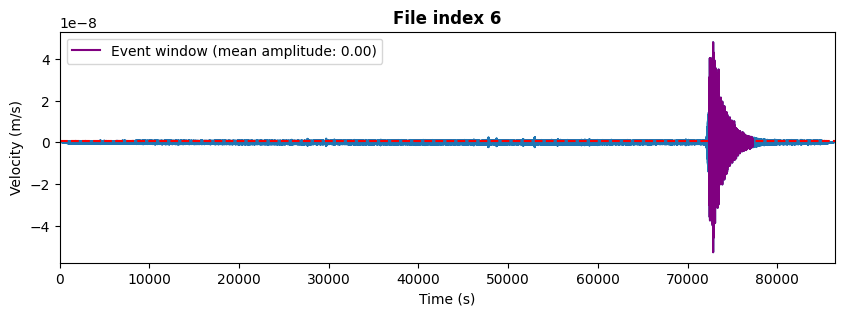

Start event window: 122000
End event window: 162000


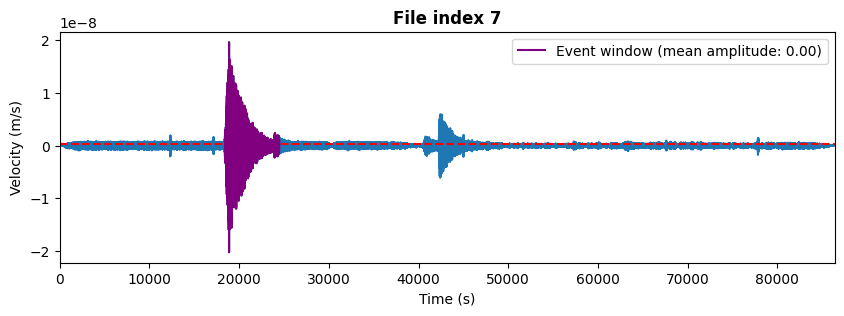

Start event window: 122000
End event window: 162000


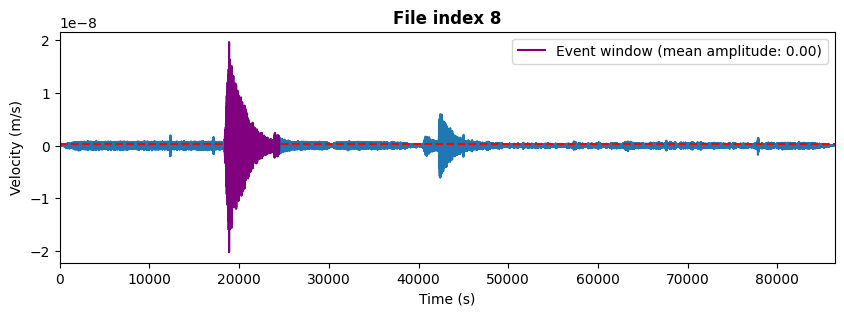

Start event window: 476000
End event window: 510000


In [ ]:
for n in range(0, 30):
    plot_test(n)